In [1]:
import sys
#sys.path.append('/home/luca/GitRepositories/Brancher')
sys.path.append('/home/luca/GitRepositories/Brancher')

import numpy as np
import matplotlib.pyplot as plt

In this tutorial we will explain how to integrate deep learning models into your Brancher pipline. 

## Bulding models with NN components

All pytorch functions can be used in Brancher. These functions need to be imported from the Brancher function module which converts all PyTorch functions acting on torch.Tensor to Brancher functions acting on brancher.Variable.

Let's get started by defining a stochastic convolutional network on the MNIST dataset. The first step is to import the dataset:

### Creating the model ##

In [2]:
import torchvision

# Data
image_size = 28
num_classes = 10
train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=None)
test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=None)
dataset_size = len(train)
input_variable = np.reshape(train.train_data.numpy(), newshape=(dataset_size, 1, image_size, image_size))
output_labels = train.train_labels.numpy()

In a Brancher model, datasets are stored in empirical variables. These are random variables that sample minibatches from a dataset.
In a supervised problem we need two empirical variables, one for the input images and the other for the labels. However, these two variables need to be sampled jointly as each image should be associated to a particular label. In Brancher, we can implement by this coupling by greating an additional RandomIndices variable that is a parent of both images and labels:

In [3]:
from brancher.standard_variables import EmpiricalVariable as Empirical
from brancher.standard_variables import RandomIndices

# Data sampling model
minibatch_size = 7

minibatch_indices = RandomIndices(dataset_size=dataset_size, batch_size=minibatch_size, 
                                  name="indices", is_observed=True)

x = Empirical(input_variable, indices=minibatch_indices, 
              name="x", is_observed=True)

labels = Empirical(output_labels, indices=minibatch_indices, 
                   name="labels", is_observed=True)

For example, we can import the PyTorch conv2d function from brancher.functions to build a stochastic 2D convolutional layer with gaussian weights. We can do this by defining oth weights and the input image as Randomvariables and using the Brancher conv2d function.

In [4]:
from brancher import functions as BF

from brancher.standard_variables import DeterministicVariable as Deterministic
from brancher.standard_variables import NormalVariable as Normal
from brancher.standard_variables import CategoricalVariable as Categorical

in_channels = 1
out_channels = 5
image_size = 28
Wk = Normal(loc=np.zeros((out_channels, in_channels, 3, 3)),
            scale=np.ones((out_channels, in_channels, 3, 3)),
            name="Wk") #Gaussian convolutional kernels
z = Deterministic(BF.relu(BF.conv2d(x, Wk, padding=1)), name="z") 

Here the random input a is convolved with the random filters W. We can now run the forward pass by sampling from the model:

In [5]:
num_samples = 6
z.get_sample(num_samples)["z"]

0    [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
1    [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2    [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3    [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4    [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
5    [[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
Name: z, dtype: object

Note that in each of these samples both the input and the weigths are sampled independently.

We can now add a linear layer to this result to get a shallow convolutional classifier. We can do this as follows

In [6]:
num_classes = 10
Wl = Normal(loc = np.zeros((num_classes, image_size*image_size*out_channels)),
            scale = np.ones((num_classes, image_size*image_size*out_channels)),
            name = "Wl")
b = Normal(loc = np.zeros((num_classes, 1)),
           scale = np.ones((num_classes, 1)),
           name = "b")
reshaped_z = BF.reshape(z, shape=(image_size*image_size*out_channels, 1))
k = Categorical(logits = BF.linear(reshaped_z, Wl, b), 
                name="k")

Here we needed to reshape the variable z as we need to perform matrix multiplication in the linear layer. Note that in Brancher you never need to explicitly consider the batch dimension. Batch properties are part of the data, not of the model and Brancher handle them automatically!

### Observing the model and training the weights ##

Now that the model is defined we need to specifiy which variables are observed. The input image variable $x$ was set as observed during model definition. The other variable to observe is the output $k$ which needs to be observed using the real labels. To this aim, we simply need to call the .observe method on $k$ with our label EmpiricalVariable as input.

In [7]:
k.observe(labels)

Done! We are now ready to learn the weights. If we are not concerned with quantifying uncertainty, we can train using maximum-a-posteriori (MAP)

100%|██████████| 600/600 [03:21<00:00,  2.95it/s]


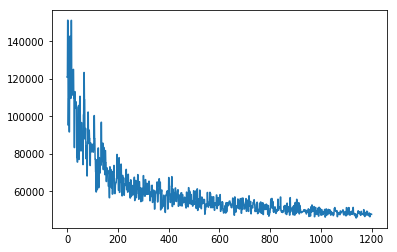

In [13]:
from brancher.inference import MAP
from brancher.inference import perform_inference
from brancher.variables import ProbabilisticModel

convolutional_model = ProbabilisticModel([k])

perform_inference(convolutional_model,
                  inference_method=MAP(),
                  number_iterations=600, #500
                  optimizer="Adam",
                  lr=0.005)
loss_list = convolutional_model.diagnostics["loss curve"]
plt.plot(loss_list)

We can finally test the model on the training set by sampling the newly trained posterior distribution. To this aim we need to call the .get_posterior_samples_method since .get_sample will result on a sample from the (untrained) prior. We also need to provide the test images as input to the this method:

In [ ]:
test_size = test.test_data.numpy().shape[0]
test_images = np.reshape(test.test_data.numpy(), newshape=(test_size, 1, image_size, image_size))

posterior_samples = convolutional_model.get_posterior_sample(num_samples = 1, 
                                                             input_values = {x: test_images[0:4,:]})

The output is one-hot encoded. Let's get the predicted labels:

In [14]:
np.argmax(posterior_samples["k"][0], axis=1)

array([[7],
       [2],
       [1],
       [0]])

## Using existing PyTorch models in a Brancher model

So far we saw how to construct Brancher models with NN building blocks. However, somethimes it is useful to pre specify a PyTorch model and use it in a Brancher model. In this case, we need to wrap the PyTorch model using the brancher.functions.BrancherFunction class. 

Let's start by defining a PyTorch network:

In [ ]:
import torch

## PyTorch model ##
class PytorchNetwork(torch.nn.Module):
    def __init__(self):
        super(PytorchNetwork, self).__init__()
        out_channels = 5
        image_size = 28
        self.l1 = torch.nn.Conv2d(in_channels=1, out_channels=out_channels, kernel_size=3, padding=1)
        self.f1 = torch.nn.ReLU()
        self.l2 = torch.nn.Linear(in_features=image_size ** 2 * out_channels, out_features=10)

    def __call__(self, x):
        h = self.f1(self.l1(x))
        h_shape = h.shape
        h = h.view((h_shape[0], np.prod(h_shape[1:])))
        logits = self.l2(h)
        return logits
    
network = PytorchNetwork()

We can now convert it into a Brancher function:

In [ ]:
## Equivalent Brancher model ##
brancher_network = BF.BrancherFunction(network)

Note that in this procedure does not create latent variables as we are treating the network as a black-box function with learnable parameters. This implies that we can train the weights using maximal likelihood but we cannot use Bayesiance inference methods on the weights.

We can now construct a Brancher model as follows

In [ ]:
# Data sampling model
minibatch_size = 4
minibatch_indices = RandomIndices(dataset_size=dataset_size, batch_size=minibatch_size,
                                  name="indices", is_observed=True)
x = Empirical(input_variable, indices=minibatch_indices,
              name="x", is_observed=True)
labels = Empirical(output_labels, indices=minibatch_indices,
                   name="labels", is_observed=True)

# Forward model #
k = Categorical(logits=brancher_network(x),
                name="k")
k.observe(labels)

We can now train using MaximulLikelihood:

In [ ]:
from brancher.inference import MaximumLikelihood
from brancher.inference import perform_inference
from brancher.variables import ProbabilisticModel

convolutional_model = ProbabilisticModel([k])

perform_inference(convolutional_model,
                  inference_method=MaximumLikelihood(),
                  number_iterations=500,
                  optimizer="Adam",
                  lr=0.001)
loss_list = convolutional_model.diagnostics["loss curve"]
plt.plot(loss_list)

Note that MaximulLikelihood trains the probabilistic model itself (the prior in Bayesian terms) and not the posterior model. Therefore, we can test the model by calling the .get_sample method instead .get_posterior_sample (the posterior is not eve defined in this model as we do not have latent variables):

In [19]:
test_size = test.test_data.numpy().shape[0]
test_images = np.reshape(test.test_data.numpy(), newshape=(test_size, 1, image_size, image_size))

np.argmax(convolutional_model.get_sample(1, input_values= {x: test_images[0:4,:]})["k"][0], axis=1)

array([[4],
       [4],
       [5],
       [4]])